## Super-Resolution Application with CPS
- infer gene expression with higher resolution of spatial position

In [1]:
import os,sys
sys.path.append(os.path.realpath(os.path.join(os.getcwd(), '..')))
import warnings
warnings.filterwarnings("ignore")

In [2]:
import scanpy as sc
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import CPS

In [3]:
opt = CPS.config()
args = opt.parse_args(['--seed', '2025'])
args.prep_scale = False
args.dataset_path = '/mnt/d/Dataset/SRT_Dataset/MBSS_Sagittal_Posterior'
args.radius=150
args.clusters=6
args.hvgs=2000
args.er_w=0.05
args.sigma=1
args.freq=32
CPS.set_random_seed(args.seed)
args.k_list = [0,1,2,3,4,5,6,7]
args

Namespace(batch_size=256, clusters=6, coord_dim=2, dataset_path='/mnt/d/Dataset/SRT_Dataset/MBSS_Sagittal_Posterior', decoder_latent=[256, 512, 1024], distill=1.0, dropout=0.2, er_w=0.05, flow='source_to_target', freq=32, gpu=0, hvgs=2000, inr_latent=[256, 256, 256], k_list=[0, 1, 2, 3, 4, 5, 6, 7], latent_dim=64, lr=0.001, max_epoch=1000, max_neighbors=6, n_spot=0, num_heads=4, prep_scale=False, radius=150, seed=2025, self_loops=True, sigma=1, weight_decay=0.0001)

In [4]:
adata = sc.read_visium(path=args.dataset_path, count_file='filtered_feature_bc_matrix.h5')
adata

AnnData object with n_obs × n_vars = 3355 × 32285
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [5]:
adata.var_names_make_unique()
adata.layers["counts"] = adata.X.copy()
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=args.hvgs)
adata_hvg = adata[:, adata.var['highly_variable']].copy()
sc.pp.normalize_total(adata_hvg, target_sum=1e4)
sc.pp.log1p(adata_hvg)
sc.pp.scale(adata_hvg, zero_center=True)

counts_layer = adata_hvg.layers['counts']
adata_hvg.obsm['hvg_features'] = adata_hvg.X
adata_hvg.obsm['hvg_counts'] = counts_layer.toarray()

In [6]:
spatial_edge = CPS.SpatialGraphBuilder(args)
pyg_data = spatial_edge.build_single_graph(adata_hvg, method='rknn')
print(pyg_data.num_nodes, pyg_data.num_genes, pyg_data.edge_index.shape)

3355 2000 torch.Size([2, 22953])


In [7]:
cps_model = CPS.CPSTrainer(args)
cps_model.fit(pyg_data, print_every=100)

  0%|          | 0/1000 [00:00<?, ?it/s]


Epoch   0: Train[Total:5.6690, T:2.5672, S:2.3255, D:0.7763]

Epoch 100: Train[Total:2.6279, T:1.0196, S:1.0358, D:0.5726]

Epoch 200: Train[Total:2.4313, T:0.9903, S:1.0024, D:0.4386]

Epoch 300: Train[Total:2.3197, T:0.9758, S:0.9851, D:0.3588]

Epoch 400: Train[Total:2.2113, T:0.9660, S:0.9738, D:0.2715]

Epoch 500: Train[Total:2.1280, T:0.9583, S:0.9655, D:0.2041]

Epoch 600: Train[Total:2.0664, T:0.9517, S:0.9593, D:0.1554]

Epoch 700: Train[Total:2.0155, T:0.9469, S:0.9543, D:0.1143]

Epoch 800: Train[Total:1.9748, T:0.9434, S:0.9499, D:0.0815]

Epoch 900: Train[Total:1.9501, T:0.9399, S:0.9466, D:0.0636]

Epoch 999: Train[Total:1.9263, T:0.9363, S:0.9431, D:0.0469]


### prepare and generate the super-resolution gene expression

In [8]:
# generate high-res coords
sr_coords = CPS.generate_sr_coords(adata_hvg, upscale_factor=2)

原始点数: 3355
生成的全网格点数: 14500
过滤背景后的 SR 点数: 11939


In [9]:
# norm and adapt to INR input
min_val = torch.FloatTensor(adata.obsm['spatial']).min(dim=0).values
max_val = torch.FloatTensor(adata.obsm['spatial']).max(dim=0).values
center = (min_val + max_val) / 2
span = max_val - min_val
scale = span.max() / 2
sr_coords_tensor = torch.FloatTensor(sr_coords)
sr_pos_norm = (sr_coords_tensor - center) / scale

In [10]:
# generate the library size for NB distribution
sr_lib_size = CPS.generate_sr_library_size(adata_hvg, sr_coords, mode='median')

Generating Library Size with mode: median


In [71]:
sr_lib_size

tensor([[50.1582],
        [50.1582],
        [50.1582],
        ...,
        [50.1582],
        [50.1582],
        [50.1582]])

In [11]:
cps_model.model.eval()
with torch.no_grad():
    z_s = cps_model.model.student(sr_pos_norm.to(cps_model.device))
    sr_expr, _ = cps_model.model.decoder(z_s, sr_lib_size.to(cps_model.device))

In [23]:
def construct_sr_adata(adata_raw, sr_expression, sr_coords):
    if torch.is_tensor(sr_expression):
        X_sr = sr_expression.detach().cpu().numpy()
    else:
        X_sr = sr_expression
        
    adata_sr = sc.AnnData(X=X_sr)
    adata_sr.var = adata_raw.var.copy()
    adata_sr.obsm['spatial'] = sr_coords
    adata_sr.obs_names = [f"SR_{i}" for i in range(adata_sr.n_obs)]
    
    if 'spatial' in adata_raw.uns:
        adata_sr.uns['spatial'] = adata_raw.uns['spatial'].copy()
    
    return adata_sr

In [24]:
adata_sr = construct_sr_adata(adata_hvg, sr_expr, sr_coords)
adata_sr

AnnData object with n_obs × n_vars = 11939 × 2000
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'spatial'
    obsm: 'spatial'

In [27]:
adata_sr.var.head()

,gene_ids,feature_types,genome,highly_variable,highly_variable_rank,means,variances,variances_norm,mean,std
Vxn,ENSMUSG00000067879,Gene Expression,mm10,True,204.0,1.374665,7.439489,2.692592,0.842393,1.094631
A830018L16Rik,ENSMUSG00000057715,Gene Expression,mm10,True,824.0,0.514754,1.160411,1.577872,0.453726,0.766555
Sulf1,ENSMUSG00000016918,Gene Expression,mm10,True,164.0,0.200894,1.005545,2.934879,0.196673,0.534884
Trpa1,ENSMUSG00000032769,Gene Expression,mm10,True,1205.0,0.002683,0.003869,1.386579,0.002374,0.054455
Ube2w,ENSMUSG00000025939,Gene Expression,mm10,True,1963.0,0.912966,1.867199,1.215492,0.828964,0.937422


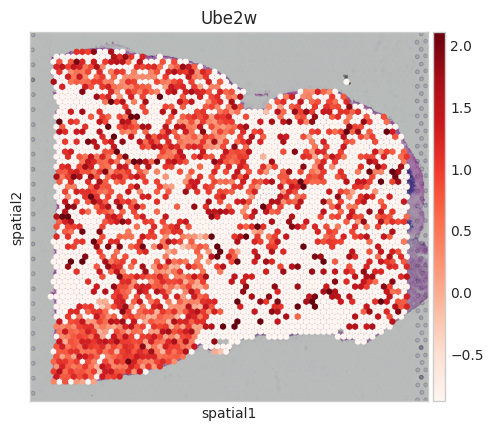

In [70]:
sc.pl.spatial(adata_hvg, color='Ube2w', spot_size=150, color_map='Reds',vmax='p99',)

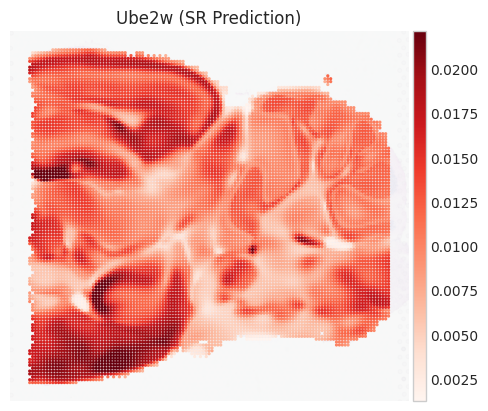

In [64]:
sc.pl.spatial(
    adata_sr, 
    color='Ube2w', 
    spot_size=75,         
    color_map='Reds',       
    vmax='p99',            
    alpha_img=0.1,        
    frameon=False,      
    title='Ube2w (SR Prediction)',
)

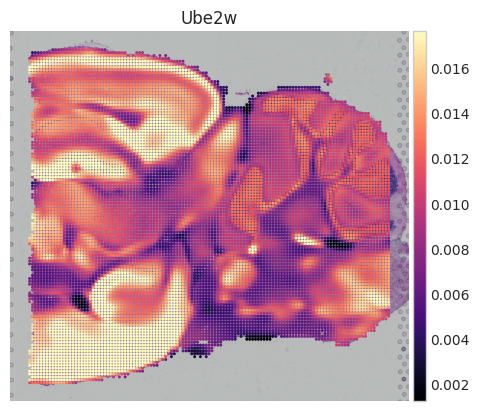

In [48]:
sc.pl.spatial(
    adata_sr, 
    color='Ube2w', 
    spot_size=70, 
    color_map='magma',      # 【推荐】Magma 配色，低表达是黑/紫，高表达是亮黄
    vmax='p90',             # 稍微激进一点，让结构更亮
    frameon=False
)

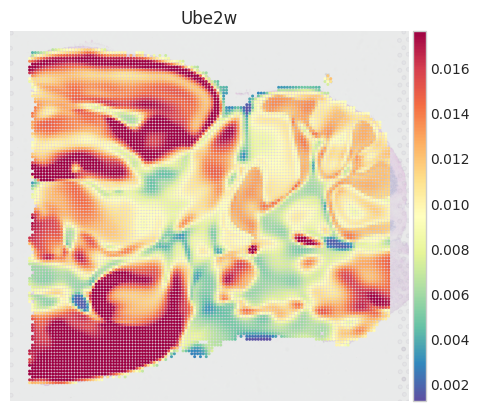

In [73]:
sc.pl.spatial(
    adata_sr, 
    color='Ube2w', 
    spot_size=70, 
    color_map='Spectral_r', # 红-黄-蓝 渐变 (注意加 _r 反转，让红代表高表达)
    vmax='p90',
    alpha_img=0.3,          # 背景图淡一点
    frameon=False
)